In [1]:
# Imports & Config

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
np.random.seed(42)

2026-01-17 20:49:02.689330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Load CIFAR-10 Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test  = y_test.flatten()

# Subsample for KNN feasibility
train_size = 5000
test_size  = 1000
X_train, y_train = X_train[:train_size], y_train[:train_size]
X_test,  y_test  = X_test[:test_size],  y_test[:test_size]

# Preprocessing
# Flatten images: 32x32x3 → 3072
X_train = X_train.reshape(len(X_train), -1) / 255.0
X_test  = X_test.reshape(len(X_test), -1) / 255.0


In [3]:
# Distance Functions

def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan(a, b):
    return np.sum(np.abs(a - b))

def minkowski(a, b, p=3):
    return np.sum(np.abs(a - b) ** p) ** (1/p)

def cosine(a, b):
    return 1 - (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hamming(a, b):
    return np.mean(a != b)

distance_funcs = {
    "Euclidean": euclidean,
    "Manhattan": manhattan,
    "Minkowski": minkowski,
    "Cosine": cosine,
    "Hamming": hamming
}

In [4]:
# KNN From Scratch (Multi-class)

def knn_predict(X_train, y_train, X_test, k, dist_fn):
    preds = []
    for x in X_test:
        dists = [(dist_fn(x, xtr), ytr) for xtr, ytr in zip(X_train, y_train)]
        dists.sort(key=lambda x: x[0])
        k_labels = [label for _, label in dists[:k]]
        preds.append(np.bincount(k_labels).argmax())
    return np.array(preds)

In [5]:
# Experimentation

K_values = [1, 3, 5, 7, 9]
results = {}

for dname, dfunc in distance_funcs.items():
    accs = []
    for k in K_values:
        y_pred = knn_predict(X_train, y_train, X_test, k, dfunc)
        accs.append(np.mean(y_pred == y_test))
    results[dname] = accs

results_df = np.array(list(results.values()))
print(results_df)


[[0.268 0.261 0.266 0.274 0.27 ]
 [0.288 0.278 0.31  0.309 0.3  ]
 [0.239 0.217 0.23  0.245 0.255]
 [0.292 0.275 0.283 0.279 0.286]
 [0.23  0.214 0.236 0.254 0.248]]


In [6]:
# Best Model + Metrics

best_dist = list(results.keys())[np.argmax(results_df.max(axis=1))]
best_k = K_values[np.argmax(results[best_dist])]

y_best = knn_predict(X_train, y_train, X_test, best_k, distance_funcs[best_dist])

conf_mat = np.zeros((10,10), dtype=int)
for t, p in zip(y_test, y_best):
    conf_mat[t][p] += 1

precision = np.mean(np.diag(conf_mat) / np.sum(conf_mat, axis=0))
recall    = np.mean(np.diag(conf_mat) / np.sum(conf_mat, axis=1))

print("Best K:", best_k)
print("Best Distance:", best_dist)
print("\nConfusion Matrix:\n", conf_mat)
print("\nPrecision:", precision)
print("Recall:", recall)


Best K: 5
Best Distance: Manhattan

Confusion Matrix:
 [[56  1 11  1  9  1  5  1 17  1]
 [13 16 12  6 16  1  6  0 16  3]
 [19  1 48  1 20  4  4  2  1  0]
 [15  1 25 21 17  7 12  1  3  1]
 [11  0 28  3 33  2  4  2  6  1]
 [10  1 26  5 19 12  6  3  3  1]
 [ 8  1 38  8 31  6 17  1  2  0]
 [ 9  2 25  7 24  3  9 17  3  3]
 [17  2  5  3  8  1  0  0 69  1]
 [20  4 11  5 16  0  5  6 21 21]]

Precision: 0.38320098639656797
Recall: 0.30756059744579656


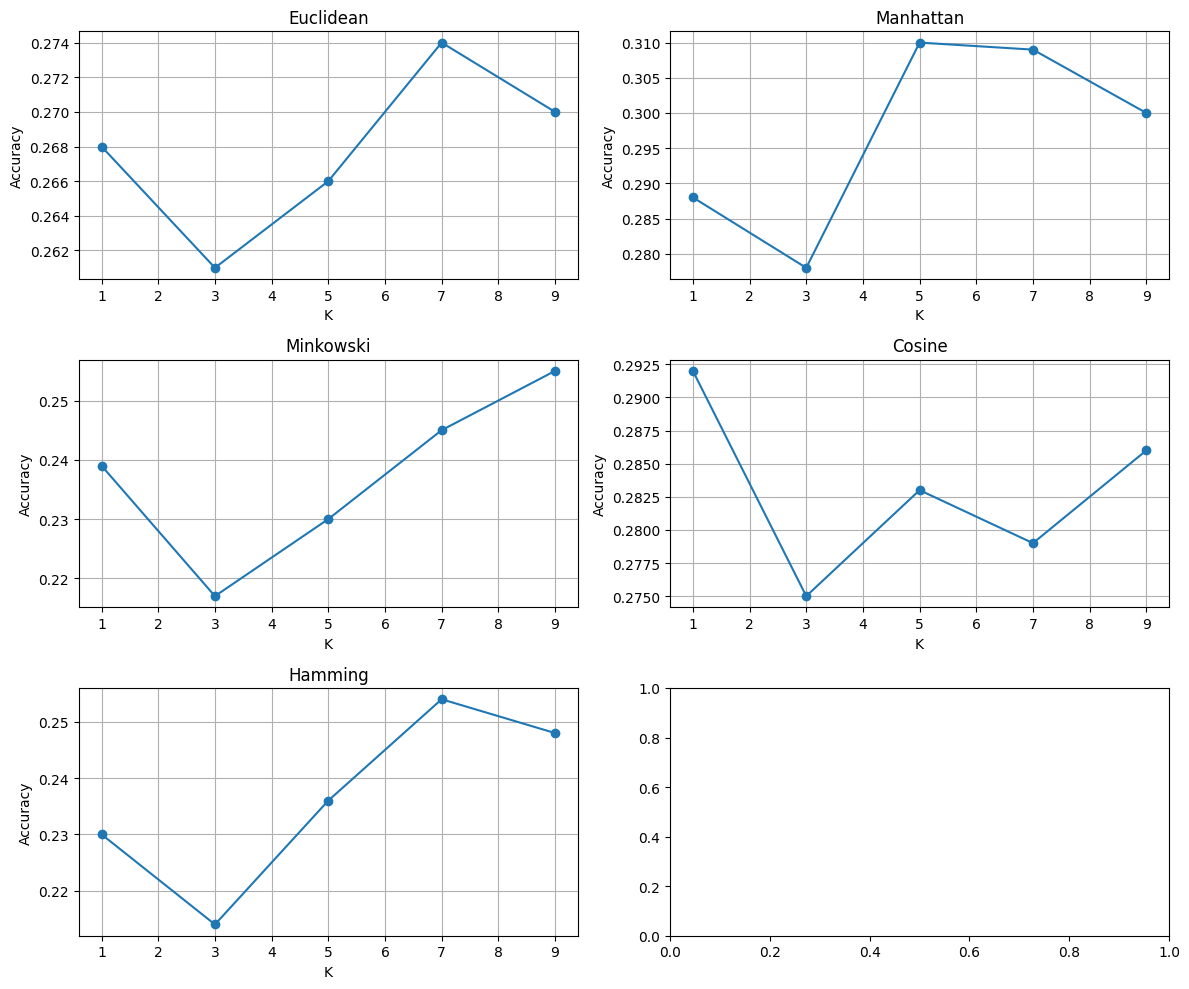

In [7]:
# Plot K vs Accuracy (Separate Plots)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (dname, accs) in zip(axes, results.items()):
    ax.plot(K_values, accs, marker='o')
    ax.set_title(dname)
    ax.set_xlabel("K")
    ax.set_ylabel("Accuracy")
    ax.grid()

plt.tight_layout()
plt.show()

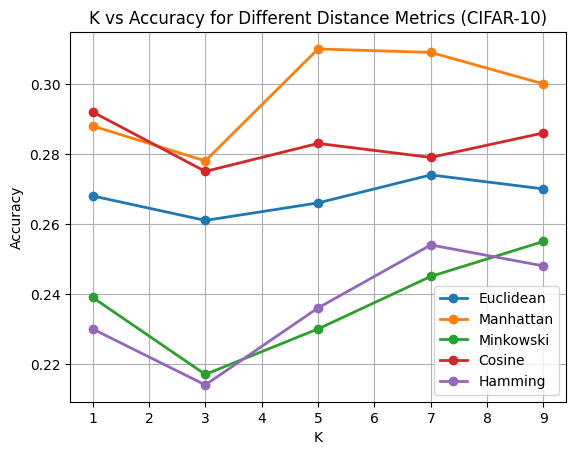

In [8]:
# Single graph: K vs Accuracy for all distance metrics

for dname, accs in results.items():
    plt.plot(K_values, accs, marker='o', linewidth=2, label=dname)

plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("K vs Accuracy for Different Distance Metrics (CIFAR-10)")
plt.legend()
plt.grid()
plt.show()


In [9]:
# Accuracy Table: Distance Metric vs K
import pandas as pd

acc_table = pd.DataFrame(
    results,
    index=K_values
)

acc_table.index.name = "K"
acc_table = acc_table.round(3)

print(acc_table)


   Euclidean  Manhattan  Minkowski  Cosine  Hamming
K                                                  
1      0.268      0.288      0.239   0.292    0.230
3      0.261      0.278      0.217   0.275    0.214
5      0.266      0.310      0.230   0.283    0.236
7      0.274      0.309      0.245   0.279    0.254
9      0.270      0.300      0.255   0.286    0.248
